In [1]:
from itertools import combinations
from scipy.stats import spearmanr
from collections import Counter
from scipy import stats
import community as community_louvain
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import pandas as pd
import numpy as np
import requests 
import random
import ast
import re 

# Network Analysis of Philosophical Concepts
### Konstantinos Bampalis - September 2024


## 1. Introduction

The purpose of this notebook is to present my work for parts 2 and 3 of the Datatonic Graduate Interview Challenge. 

Philosophy is a very broad and diverse field with many subfields whose categorization is not always clear. Many schools of thought exist and most philosophical works and ideas span ideas from various schools. The purpose of this analysis is to understand how philosophical schools are connected to each other using a dataset of books tagged under the "Philosophy" subject classification from the OpenLibrary API.

We will construct a graph $G = (V,E,w)$, where $V$ is a set of vertices, $E$ is a set of edges and $w: E \rightarrow \mathbb{R}^{+}$ is a weight function on the set of edges. The vertices will represent the most common or major schools of thought and an edge between two vertices is present if there exists at least one book that spans both schools of thought. The weight function simply measures the frequency of co-occurences; An edge is weighted by $+1$ if subjects $i,j$ for $i \neq j$ appear together in a given book. The final product will be a network that will try to capure relationships between schools of thought are distributed across the books that are in the dataswet.

The methodology of this exploration was as follows: We first obtain the dataset by calling the OpenLibrary API using the requests library in Python. The fetched data is saved into a raw csv file, "raw-phil.csv". The next step is to clean the dataset - as with most data analysis tasks, this process turned out to be the most challenging and required a lot of fine tuning. In this analysis, cleaning required to find a way to normalize the categories that each raw book fell into, into a well - defined and standard school of thought. To test that the cleaned dataset accuretely represents these schools of thought, as a quality assurance measure I manually reviewed a sample of books and from there, infered what percentage of the books have been accurately categorized. The next step is to perform the analysis on the clean dataset. Firstly, I calulcated some basic summary statistics to get a feel for the dataset. These statistics helped me understand the distribution of schools of thought in the books, understand multi-category books and common co-occurences between schools of thought, see on the number of categories that each book falls into and understand how schools of thought are correlated.
These measures, while basic gave a solid understanding of the dataset, helped confirm that the analysis is heading towards the right path and assess expectations for the network analysis. Next, using the networkx library, I performed the network analysis. The first step was to construct the network.After, I completeted the remaining of the analysis. The first step was to calculate some basic network statistics. Network statistics stem from standard graph theoretic termninology. The number of vertices illustrates the number of distinct schools of thought/categories. The number of edges shows the overall connectedness in the network and the density calculates the proportion of potential connections that actually materialize. Prior to the analysis, using both domain analysis and inspection of the dataset, I expected that the network would be very close to being complete, and this was later confirmed by the analysis. The average degree per node will illustrate how many connections each category has on average. In any graph, a path between two vertices $a$ and $b$ is the distance from $a$ to $b$, in our case, this is simply the number of edges that need to be covered to reach $b$, from $a$. In the context of analyzing schools of philosophical thought, understanding path statistics is useful since we can understand how ideas, influences and ideas spread. For example, if there exists a short path between Existensialism and the Philosophy of Phsychiatry then this means that these fields influence each other. For these purposes, I calculated several Path statistics. Clearly, if we wanted to find the shortest path between any two schools of thought, then this would be $1$ since there are at least two schools of thought that are connected. As a metric, the shortest path (or the average shortest path), does not say much. A better measure is to calculate the diameter of the graph which calculates the longest shortest path between any two nodes. This will help us understand the overall spread of connections among schools of thought. A small diameter was expected and again this result was confirmed by the analysis. Another useful metric is to understand which of Schools of Thought seem to be the most influential.Centrality measures help in identifying the most important vertices in a network based on certain criteria. The main metrics calculated were the following: Degree Centrality which measures the number of direct connections a vertex has; in this context this will represent the school of thought that co-occurs with the most schools of thought. Betweeness Centrality measures the frequency of a node lying on a shortest path between any two vertices; This will show which Schools of Thought tend to act as bridges. Closeness Centrality classifies a vertex based on how close it is to all other vertices in the graph; if a School of Thought scores high on that metric then it means that that school can reach every other school in relatively few steps. This means that this school is a "key player". Eigenvector Centrality measures how influential a vertex is in the network by counting its connections and considering the importance of its connections, giving us some sort of recursive understanding of infulence; it is not enought to just be well-connected, a node needs to be well-connected to other infulential nodes. Similar to EigenCentrality is PageRank which takes into account the probability of reaching a vertex by "walking" randomly on the graph. A School of Thought that scores high on that measure will be reached frequently within the network. This suggests that that School of Thought plays a significant role while a school of thought with low PageRank score might suggest that this school is more nieche or specialized. The last part of the Analysis is to split the schools of thought into clusters or communities by using the Louvain Method for community detection. 

The remaining of the notebook is structured as follows; Sections 2 discussed the dataset construction and cleaning processes. Section 3 illustrates the code and results from the analysis and finally Section 4 conludes by discussing the results and suggesting ways for extensions and improvements.

## 2. Dataset Construction and Data Cleaning 


### Dataset Construction: 
The dataset was fetched and saved into a csv file using the following script; We obtain 5000 books that have been tagged as philosophy in the subject field. The choice of this sample size was made to obtain a dataset that is large enough to even out any data discrepancies. The first few rows of the raw dataset are shown after the script.


In [2]:
def dataFetch(q="subject: philosophy", l=5000):
    apiURL =  "https://openlibrary.org/search.json"
    params = {
        "q": q,
        "limit": l,
        "fields": "key,title,author_name,first_publish_year,subject,language,publisher,number_of_pages_median,ebook_count_i,edition_count,ratings_average,ratings_count"
    }

    try:
        resp = requests.get(apiURL, params = params)
        resp.raise_for_status()
        return resp.json()
    except requests.RequestException as e:
        print("Error in the Data Fetch process")
        return None


def main():
    print("Fetching Data")
    data = dataFetch(q="subject: philosophy", l=5000)

    if data is None or "docs" not in data:
        print("Failed")
        return 
    else:
        try:
            df = pd.DataFrame(data["docs"])
            outputFile = "raw-phil.csv"
            df.to_csv(outputFile, index=False)
            print("Data is saved in the output file")
        except Exception as e:
            print(f"Error processing or saving data: {e}")

if __name__ == "__main__":
    main()
    

Fetching Data
Data is saved in the output file


In [3]:
df=pd.read_csv("raw-phil.csv")
df.head()

,author_name,ebook_count_i,edition_count,first_publish_year,key,language,number_of_pages_median,publisher,title,subject,ratings_average,ratings_count
0,['Will Durant'],13,110,1926.0,/works/OL1073964W,"['ger', 'hun', 'urd', 'chi', 'eng', 'heb', 'dan']",543.0,"['Clarion', 'Time Incorporated', 'New Star Pre...",The Story of Philosophy,"['Philosophy', 'Philosophers', 'History', 'Phi...",4.250000,8.0
1,['Friedrich Nietzsche'],17,209,1885.0,/works/OL98174W,"['ita', 'ger', 'eng']",201.0,"['Cambridge University Press', 'A. Kröner', '...",Jenseits von Gut und Böse,"['Ethics', 'Philosophy', 'Translations into En...",4.312500,16.0
2,['Laozi'],37,190,1875.0,/works/OL45503W,"['vie', 'jpn', 'may', 'eng', 'rus', 'kor', 'th...",165.0,"['Center for Chinese Studies, University of Mi...",The Sayings of Lao Tzü,"['Taoism', 'Chinese Philosophy', 'Asian Philos...",4.400000,5.0
3,['René Descartes'],12,163,1644.0,/works/OL1151518W,"['eng', 'spa', 'ita', 'heb', 'lat', 'fre']",185.0,"['J. Vrin', 'Marabout', 'Phoenix (an Imprint o...",Discours de la méthode,"['Methodology', 'Science', 'Modern Philosophy'...",4.000000,7.0
4,['Πλάτων'],24,231,1675.0,/works/OL51948W,"['ita', 'fre', 'mul', 'grc', 'lat', 'eng', 'tw...",112.0,"['Secretaría de educación pública', 'Alhamb...",Ἀπολογία Σωκράτους,"['Nonfiction', 'Philosophy', 'OverDrive', 'Acc...",4.142857,28.0


We now move to the Data Cleaning process. Observe that if we take any random book from the raw dataset, its subject list is not consistent, contains a lot of overlaps and therefore, existing subject tags cannot be used as a categorization scheme. The main challenge of the data cleaning was to find a good enough normalization process and to categorize the books as accurately as possible into a standard set of Philosophical Schools of Thought. My approach was as follows, in pseudocde:

define a list of standardized schools of thought <br>
define a dictionary where each key is a school of thought from the list and each corresponding value is a list of keywords related to that school <br>
iterate throught each book in the dataset <br>
if its subject tags match any word from the dictionary then we categorize the book under that school of thought. <br>

Example:

In [ ]:
"""
schoolOfThought = ["Aesthetics",...,"Logic"]
schoolOfThoughtDict= {
    "Aesthetics": ["art","aesthetics"], 
    ...,
    "Logic": ["logic", "godel", "incompleteness","deduction"]
}

Given book x from the dataset, if any of its raw subject keywords is any element of the lists in the dictionary, it will be categorized as such.
"""

In [5]:
philSchool = [
    "Philosophy of Science", "Philosophy of Economics", "Philosophy of Language", "Philosophy of Mind",
    "Philosophy of Psychiatry", "Philosophy of Nature", "Philosophy of Religion", "Philosophy of Gender",
    "Aesthetics","Epistemology","Ethics","Existentialism","Logic","Metaphysics", "Phenomenology",
    "Political Philosophy","Ancient Philosophy","Critical Theory"
]

philDict = {

    "Philosophy of Science": ["physics","quantum","causality","causation","methodology","scientific"], 
    "Philosophy of Economics": ["economics","economic","markets","utility","capitalism","capital","communism","marx","marxian","marxism","socialism","wealth","business","finance","financial"], 
    "Philosophy of Language": ["semantics", "linguistics"], 
    "Philosophy of Mind": ["mind","cognition","consciousness"],
    "Philosophy of Psychiatry": ["psychiatry","psychoanalysis","psychotherapy","schizophrenia"], 
    "Philosophy of Nature": ["nature","ecology"], 
    "Philosophy of Religion": ["religion","god","faith","theism","atheism","christianity","hinduism","Buddhism","islam"], 
    "Philosophy of Gender": ["gender","feminism","feminist","queer","intersectionality","gender","gay","lesbian","lesbianism","LGBT", "LGBTQ","homophobia"],
    "Aesthetics": ["aesthetics","art","aesthetic","perception"],
    "Epistemology": ["epistemology","epistemic","Empiricism"],
    "Ethics": ["ethics", "ethical", "utilitarianism","bioethics"],
    "Existentialism": ["existentialism","existential"],
    "Logic": ["logic","logics","Gödel", "logical"],
    "Metaphysics": ["metaphysics","necessity","determinism", "ontology"],
    "Phenomenology": ["phenomenology"],
    "Political Philosophy": ["politics","political","democracy","anarchism","totalitarianism","fascism","nationalism","state","rights","utopia","authoritarianism"],
    "Critical Theory": ["frankfurt","ideology","dialectic","structuralism","postmodernism"],
    "Ancient Philosophy": ["ancient","roman","socratic","platonic","aristoelian","stoic","stoics","stoicism","presocratics","presocratic","sophists","hellenistic","neoplatonism"]
}

def cleanText(text):
    try:
        text_str = str(text)
        return re.sub(r'[^\w\s]', '', text_str.lower())
    except Exception as e:
        print(f"Error in cleanText: {e}")
        return ""

def cleanAuthorName(name):
    try:
        name_str = str(name)
        cleaned = re.sub(r'[^\w\s\'-]', '', name_str)
        return ' '.join(cleaned.split())
    except Exception as e:
        print(f"Error in cleanAuthorName: {e}")
        return ""

def catBooks(subjects):
    try:
        if isinstance(subjects, str):
            subjects = [subjects]
        
        categories = []
        for subject in subjects:
            words = cleanText(subject).split()
            for category, keywords in philDict.items():
                if any(keyword in words for keyword in keywords):
                    categories.append(category)
        
        return list(set(categories)) or ["Uncategorized"]
    except Exception as e:
        print(f"Error in catBooks: {e}")
        return ["Uncategorized"]

def processData(input_file):
    try:
        df = pd.read_csv(input_file)
        
        df['clean_title'] = df['title'].apply(cleanText)
        df['clean_author'] = df['author_name'].apply(cleanAuthorName)
        df['clean_subject'] = df['subject'].apply(catBooks)
        
        return df
    except Exception as e:
        print(f"Error in processData: {e}")
        return None

def main():
    input_file = "raw-phil.csv"  
    output_file = "clean-philTest.csv"  
    
    try:
        df_cleaned = processData(input_file)
        if df_cleaned is not None:
            df_cleaned.to_csv(output_file, index=False)
            print(f"\nCleaned and categorized data saved to {output_file}")
        else:
            print("Data processing failed")
    except Exception as e:
        print(f"Error in main: {e}")

if __name__ == "__main__":
    main()




Cleaned and categorized data saved to clean-philTest.csv


Parts of the clean dataset are shown below. 

In [6]:
df = pd.read_csv("clean-philTest.csv")
df.head()

,author_name,ebook_count_i,edition_count,first_publish_year,key,language,number_of_pages_median,publisher,title,subject,ratings_average,ratings_count,clean_title,clean_author,clean_subject
0,['Will Durant'],13,110,1926.0,/works/OL1073964W,"['ger', 'hun', 'urd', 'chi', 'eng', 'heb', 'dan']",543.0,"['Clarion', 'Time Incorporated', 'New Star Pre...",The Story of Philosophy,"['Philosophy', 'Philosophers', 'History', 'Phi...",4.250000,8.0,the story of philosophy,'Will Durant',['Uncategorized']
1,['Friedrich Nietzsche'],17,209,1885.0,/works/OL98174W,"['ita', 'ger', 'eng']",201.0,"['Cambridge University Press', 'A. Kröner', '...",Jenseits von Gut und Böse,"['Ethics', 'Philosophy', 'Translations into En...",4.312500,16.0,jenseits von gut und bose,'Friedrich Nietzsche',['Ethics']
2,['Laozi'],37,190,1875.0,/works/OL45503W,"['vie', 'jpn', 'may', 'eng', 'rus', 'kor', 'th...",165.0,"['Center for Chinese Studies, University of Mi...",The Sayings of Lao Tzü,"['Taoism', 'Chinese Philosophy', 'Asian Philos...",4.400000,5.0,the sayings of lao tzu,'Laozi',"['Aesthetics', 'Philosophy of Religion']"
3,['René Descartes'],12,163,1644.0,/works/OL1151518W,"['eng', 'spa', 'ita', 'heb', 'lat', 'fre']",185.0,"['J. Vrin', 'Marabout', 'Phoenix (an Imprint o...",Discours de la méthode,"['Methodology', 'Science', 'Modern Philosophy'...",4.000000,7.0,discours de la méthode,'René Descartes',"['Philosophy of Science', 'Metaphysics']"
4,['Πλάτων'],24,231,1675.0,/works/OL51948W,"['ita', 'fre', 'mul', 'grc', 'lat', 'eng', 'tw...",112.0,"['Secretaría de educación pública', 'Alhamb...",Ἀπολογία Σωκράτους,"['Nonfiction', 'Philosophy', 'OverDrive', 'Acc...",4.142857,28.0,ἀπολογία σωκράτους,'Πλάτων',['Ancient Philosophy']


Upon first inspection, it seems like the dataset does its job fairly well. For example, we see that Rene Descartes work on the "discours de la méthode" ("Discourse on the Method") is categorized in Metaphysics and Philosophy of Science (Descartes’ method is one of the most important pillars of his philosophy and science. This entry introduces readers to Descartes’ method and its applications in optics, meteorology, geometry, and metaphysics. from the Stanford Encyclopedia of Philosophy)

However, we need to understand any drawbacks\limitations of this approach and of the raw dataset as they are likely to affect the robustness of any subsequent analysis. 

First of all, this approach is very dictionary - depedent; Changes in the keywords will affect to a great extent the categorization process. One the one hand, this is makes this approach very flexible and easy to use. On the other hand, changes might produce inconsistent results. Further, depending on how the keywords are selected, bias might be introduced leading to over or under representation of certain categories.

A significant drawback is the fact that words from the raw subject column are split and considered individually. Take the subject tag "political science". My code will consider "political" and "science" separately, potentially leading to under or over categorization. That is a book whose main category should be in "Political Philosophy" would be mistakenly categorized in "Political Philosophy" AND "Philosophy of Science" (and perhaps) others, giving a false connection between these two schools of thought. To remedy this, I decided to exclude extremely broad terms (like science) and focus on more niche termninology that is present in the raw dataset. Combined with a large dataset, the wrong categorizations are averaged out. 

Despite its simplicity, the curerent method offers several advantages and this is why I decided to keep it. First, it is simple, straightforward and computatioanlly efficient. It is very easy to test and play with and easy to improve it by employing domain knowledge. It is robust to phrasing and upon inspection categorizes a significant portion of the books into their correct category. 

Another issue that came up was the fact that some books shouldn't be there in the first place. From inspecting the dataset, there were books which were wrongly classified under Philosophy in the Open Library API. A couple of books from the raw data set were Introduction to Philosophy or Histories of Philosophy. These books were usually categorized very broadly, so I took the decision to keep such books uncategorized as they dont add much to the analysis. 

Finally, Philosophy is a very broad and diverse field so to understand how to break the schools down presented a challenge in itself. Classification could be done by Time Period, by Methodological Schools of Thought or something else. Categorizing such a diverse field required a very fine balane between automating most of the categorization and manually using domain knowledge.  
 


In order to quantify the issues of the dataset, I employed the following approach: setup a manual reviewing process in which I will take a sample of size $N$ and check two thingds; (i) is the book genuinely a philosophy book? (ii) is it correctly categorized? These results are saved in two separate columns and from there we can use the sample results to infer information about the overall corectness of the dataset. Specifically, this part works as follows; I took a random sample of the clean DataSet and constructed two extra columns, isPhilosophy and isCorrect; the former 1 takes yes if the book has been correctly classified as a Philosophy book and 0 otherwise and the isCorrect Column takes 1 if the categorization was correct, 0 if it wasn't and -- in the case where the book was not a Philosophy book. Then, by checking the proportion of the correct philosophy books in the sample, I tried to infer population characteristics. The same process was used to infer correctness for classification. In this case books whose isPhilosophy category was greater than 1 and the isCorrect category was not --.


In [10]:
def manualReview(file_path, confidence_level=0.95):
    try:
     
        df = pd.read_csv(file_path)
        
     
        sample_size = len(df)
        philosophy_books = df['isPhilosophy'] == 1 
        philosophy_rate = philosophy_books.mean() #proportion of philosophy books in the sample
        
        df['isCorrect'] = df['isCorrect'].replace(['--', '—'], np.nan) 
        df['isCorrect'] = pd.to_numeric(df['isCorrect'], errors='coerce')
        
        classificationRate = df.loc[philosophy_books, 'isCorrect'].mean() #proportion of correcly classified books

        errorMargin = stats.norm.ppf((1 + confidence_level) / 2) * np.sqrt((philosophy_rate * (1 - philosophy_rate)) / sample_size)
        ciLower = max(0, philosophy_rate - errorMargin)
        ciUpper = min(1, philosophy_rate + errorMargin)
        
        print(f"\nSample size: {sample_size}")
        print(f"Number of philosophy books: {philosophy_books.sum()}")
        print(f"Estimated proportion of philosophy books: {philosophy_rate:.2f}")
        print(f"Estimated proportion of correctly classified philosophy books: {classificationRate:.2f}")
        print(f"{confidence_level*100}% Confidence Interval for proportion of philosophy books: ({ciLower:.2f}, {ciUpper:.2f})")
        
        if philosophy_books.sum() > 0 and not np.isnan(classificationRate):
            errorMarginClassified = stats.norm.ppf((1 + confidence_level) / 2) * np.sqrt((classificationRate * (1 - classificationRate)) / philosophy_books.sum())
            ciLowerClassified = max(0, classificationRate - errorMarginClassified)
            ciUpperClassified = min(1, classificationRate + errorMarginClassified)
            print(f"{confidence_level*100}% Confidence Interval for proportion of correctly classified philosophy books: ({ciLowerClassified:.2f}, {ciUpperClassified:.2f})")
        else:
            print("Unable to calculate confidence interval for correctly classified philosophy books.")
        
        return df, philosophy_rate, classificationRate, (ciLower, ciUpper)
    except Exception as e:
        print(f"Error in analyze_manual_review: {e}")
        return None, None, None, (None, None)

try:
    file_path = "randomSample.csv"  
    sample, phil_rate, class_rate, ci = manualReview(file_path)

except Exception as e:
    print(f"Error in main execution: {e}")


Sample size: 99
Number of philosophy books: 72
Estimated proportion of philosophy books: 0.73
Estimated proportion of correctly classified philosophy books: 0.75
95.0% Confidence Interval for proportion of philosophy books: (0.64, 0.82)
95.0% Confidence Interval for proportion of correctly classified philosophy books: (0.65, 0.85)


From the quality assurance we see that we are relatively good; The estimated proportions of philosophy books and correctly classified philosophy books are $73$% and $75$%, respectively. From the confidence intervals, we can see that with 95% confidence the population values lie between $(0.64,0.82)$ and $(0.65,0.85)$. Clearly, if these values fall in the lower side, our analysis will not be so accurate, so these values should always be kept in mind.

## 3. Basic Dataset Statistics


In [13]:
#convert every clean subject col into list
def convert_to_list(x): 
    if isinstance(x, str):
        return ast.literal_eval(x)
    return x

#to filter out uncategorized books
def is_not_uncategorized(x): 
    if isinstance(x, list):
        return "Uncategorized" not in x
    return True

def count_categories(x):
    if isinstance(x, list):
        return len(x)
    return 0

def abs_correlation(x):
    return abs(x[2])

def datasetAnalysis(filepath):
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Error: File '{filepath}' not found.")
        return
    except pd.errors.EmptyDataError:
        print("Error: No data found in the file.")
        return
    except pd.errors.ParserError:
        print("Error: Failed to parse the file.")
        return

    print("Basic Information about the dataset")

    try:
        # Convert the string representation of lists into actual lists
        df['clean_subject'] = df['clean_subject'].apply(convert_to_list)

        # Filter out books categorized as "Uncategorized - select only rows where unncategorized is not present"
        df = df[df['clean_subject'].apply(is_not_uncategorized)]

        # 1. Distribution of Philosophical Categories
        categoryCounts = pd.Series([category for sublist in df['clean_subject'] for category in sublist]).value_counts()
        print("1. Distribution of Philosophical Categories:")
        print(categoryCounts)
        print("\nPercentage of books per category:")
        print((categoryCounts / len(df) * 100).round(2))

        # 2. Multi-category Books
        df['category_count'] = df['clean_subject'].apply(count_categories) #add a new column to count categories 
        multiCategory = df[df['category_count'] > 1]
        print(f"\n2. Books spanning multiple philosophical categories:")
        print(f"   Total: {len(multiCategory)} ({len(multiCategory)/len(df)*100:.2f}% of all books)")
        print("\n   Sample of multi-category books:")
        print(multiCategory[['title', 'clean_subject']].head())

        # 3. Category Co-occurrence
        categoryPairs = [pair for categories in df['clean_subject'] for pair in combinations(sorted(categories), 2)] #all category paris 
        coOccurence = Counter(categoryPairs) #count unique pairs 
        print("\n3. Top 10 Co-occurring Philosophical Categories:")
        for pair, count in coOccurence.most_common(10):
            print(f"   {pair[0]} and {pair[1]}: {count} occurrences")

        # 4. Books with the Most Philosophical Categories
        mostCategories = df.nlargest(10, 'category_count')
        print("\n4. Books Spanning the Most Philosophical Categories:")
        print(mostCategories[['title', 'clean_subject', 'category_count']])

        # 5. Average Number of Categories per Book
        avgCategories = df['category_count'].mean()
        print(f"\n5. Average Number of Philosophical Categories per Book: {avgCategories:.2f}")

        # 6. Correlation between Categories
        categoryDummies = pd.get_dummies(df['clean_subject'].explode()).groupby(level=0).sum()
        correlationMat = categoryDummies.corr()
        print("\n6. Top 5 Highest Correlations between Categories:")
        corrPairs = [(correlationMat.columns[i], correlationMat.columns[j], correlationMat.iloc[i, j])
                      for i in range(len(correlationMat.columns))
                      for j in range(i + 1, len(correlationMat.columns))]
        topCorrelations = sorted(corrPairs, key=abs_correlation, reverse=True)[:5]
        for cat1, cat2, corr in topCorrelations:
            print(f"   {cat1} and {cat2}: {corr:.2f}")

        # 7. Category Exclusivity
        categoryExcl = categoryCounts / df['category_count'].sum()
        categoryExclPercentage = (categoryExcl * 100).round(2)
        print("\n7. Category Exclusivity (how often a category appears alone):")
        print(categoryExclPercentage.sort_values(ascending=False).head(10))

        print("\n--- End of Analysis ---")
    except Exception as e:
        print(f"Error during dataset analysis: {e}")

def main():
    try:
        filepath = "clean-philTest.csv"
        datasetAnalysis(filepath)
    except Exception as e:
        print(f"Error in main: {e}")

if __name__ == "__main__":
    main()

    

Basic Information about the dataset
1. Distribution of Philosophical Categories:
Philosophy of Religion      654
Political Philosophy        556
Ethics                      410
Aesthetics                  394
Ancient Philosophy          315
Philosophy of Science       290
Philosophy of Economics     240
Philosophy of Mind          203
Metaphysics                 162
Philosophy of Nature        141
Logic                       134
Philosophy of Psychiatry    115
Philosophy of Language       68
Existentialism               67
Philosophy of Gender         66
Critical Theory              62
Epistemology                 39
Phenomenology                27
Name: count, dtype: int64

Percentage of books per category:
Philosophy of Religion      22.73
Political Philosophy        19.33
Ethics                      14.25
Aesthetics                  13.69
Ancient Philosophy          10.95
Philosophy of Science       10.08
Philosophy of Economics      8.34
Philosophy of Mind           7.06
Metaphysic

## 4. Network Construction and Analysis


1. Basic Network Statistics:
Number of Vertices: 18
Number of Edges: 130
Network Density: 0.8497
Average Degree: 14.4444
Diameter: 2
Average Path Length: 1.1503


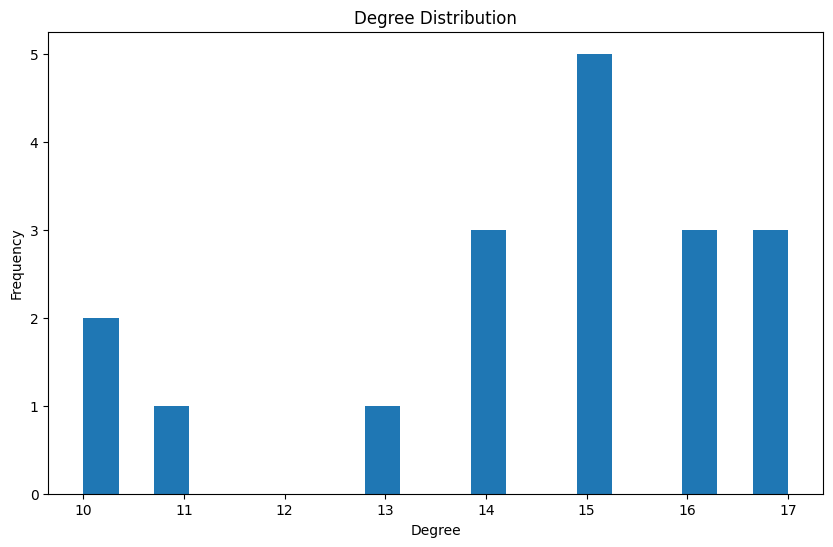


2. Centrality Measures:


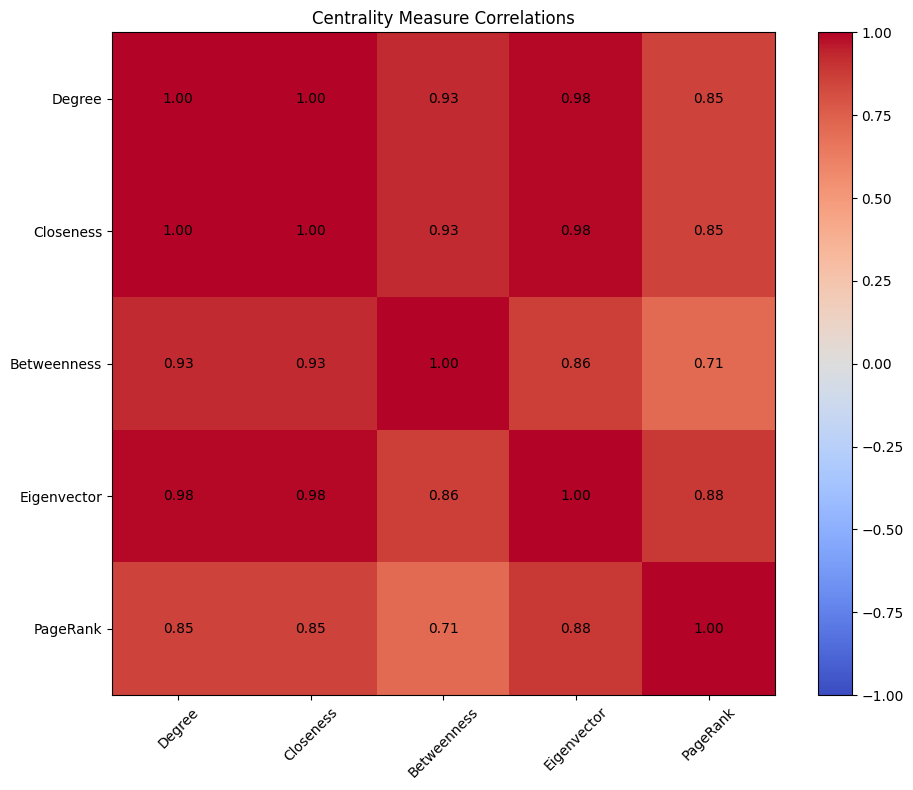


3. Community Detection:
Number of communities: 3


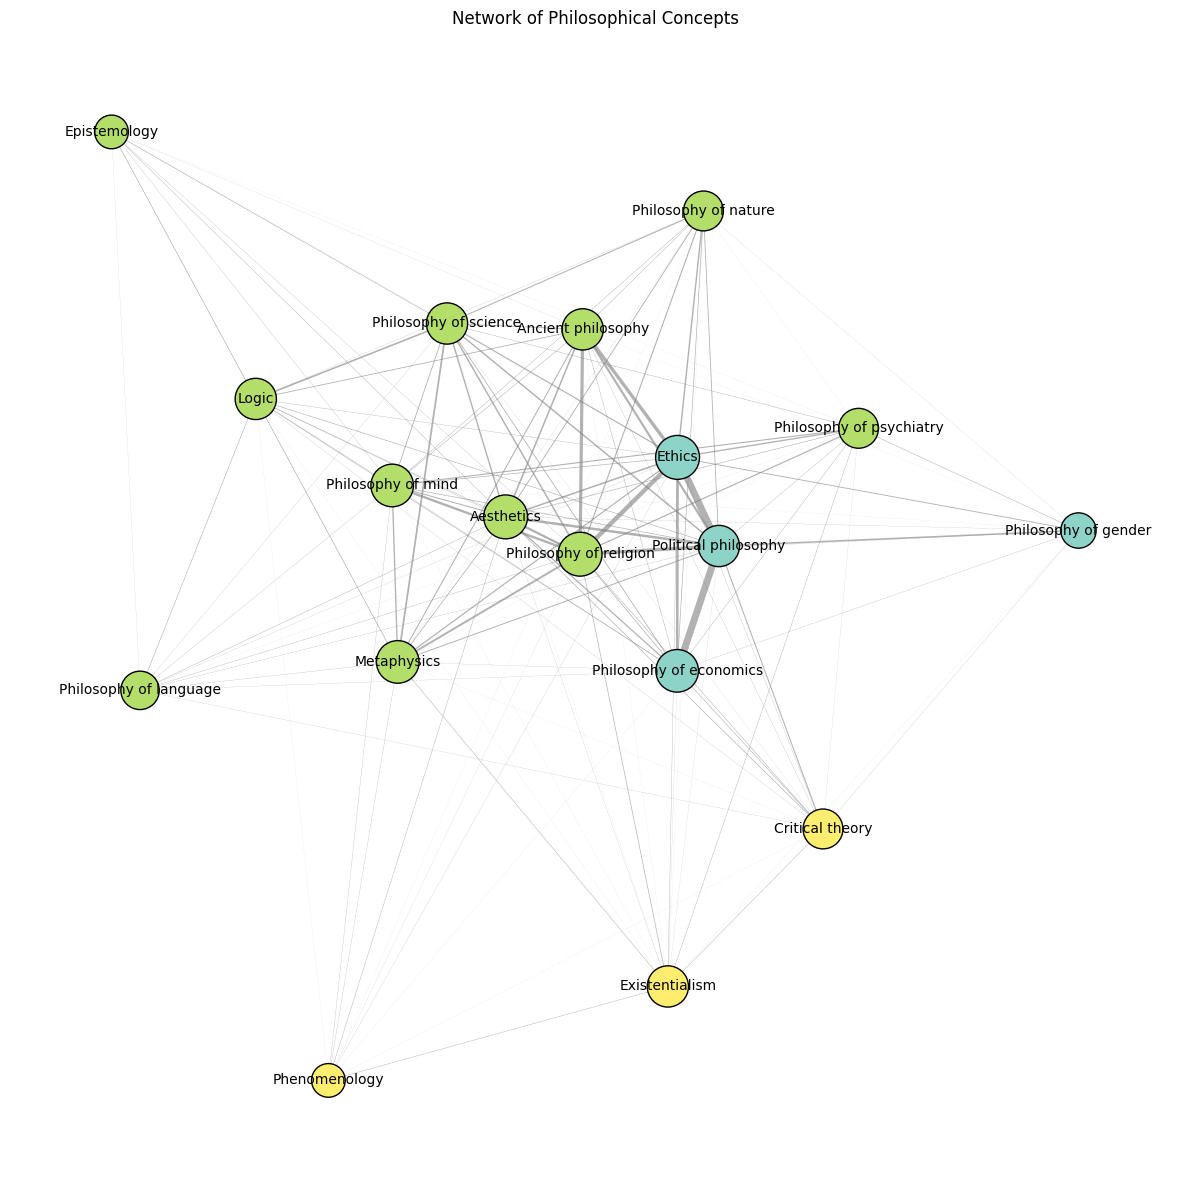


Top 10 nodes for each centrality measure:

Top 10 Degree Centrality:
Aesthetics: 1.0000
Philosophy of religion: 1.0000
Ethics: 1.0000
Metaphysics: 0.9412
Philosophy of economics: 0.9412
Philosophy of mind: 0.9412
Philosophy of science: 0.8824
Ancient philosophy: 0.8824
Existentialism: 0.8824
Political philosophy: 0.8824

Top 10 Closeness Centrality:
Aesthetics: 1.0000
Philosophy of religion: 1.0000
Ethics: 1.0000
Metaphysics: 0.9444
Philosophy of economics: 0.9444
Philosophy of mind: 0.9444
Philosophy of science: 0.8947
Ancient philosophy: 0.8947
Existentialism: 0.8947
Political philosophy: 0.8947

Top 10 Betweenness Centrality:
Aesthetics: 0.0176
Philosophy of religion: 0.0176
Ethics: 0.0176
Philosophy of mind: 0.0157
Metaphysics: 0.0126
Philosophy of economics: 0.0112
Logic: 0.0106
Ancient philosophy: 0.0104
Philosophy of psychiatry: 0.0097
Critical theory: 0.0095

Top 10 Eigenvector Centrality:
Aesthetics: 0.2676
Philosophy of religion: 0.2676
Ethics: 0.2676
Philosophy of economics

In [9]:

try:
    # Set random seeds for reproducibility
    random.seed(42)
    np.random.seed(42)

    # Load the cleaned data
    df = pd.read_csv("clean-PhilTest.csv")

    # Create the graph
    G = nx.Graph()

    # Add edges based on co-occurrence of subjects in the same book
    for _, row in df.iterrows():
        try:
            subjects = eval(row['clean_subject'])
            subjects = [subject.strip().lower().capitalize() for subject in subjects]
            for i in range(len(subjects)):
                for j in range(i + 1, len(subjects)):
                    if G.has_edge(subjects[i], subjects[j]):
                        G[subjects[i]][subjects[j]]['weight'] += 1
                    else:
                        G.add_edge(subjects[i], subjects[j], weight=1)
        except Exception as e:
            print(f"Error processing row: {e}")

    # 1. Basic network statistics
    try:
        print("1. Basic Network Statistics:")
        print(f"Number of Vertices: {G.number_of_nodes()}")
        print(f"Number of Edges: {G.number_of_edges()}")
        print(f"Network Density: {nx.density(G):.4f}")
        print(f"Average Degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.4f}")
        print(f"Diameter: {nx.diameter(G)}")
        print(f"Average Path Length: {nx.average_shortest_path_length(G):.4f}")

        # Degree distribution
        degrees = [d for n, d in G.degree()]
        plt.figure(figsize=(10, 6))
        plt.hist(degrees, bins=20)
        plt.title("Degree Distribution")
        plt.xlabel("Degree")
        plt.ylabel("Frequency")
        plt.show()
    except Exception as e:
        print(f"Error calculating basic network statistics: {e}")

    # 2. Centrality measures
    try:
        print("\n2. Centrality Measures:")
        degreeCentrality = nx.degree_centrality(G)
        closenessCentrality = nx.closeness_centrality(G)
        betweennessCentrality = nx.betweenness_centrality(G)
        eigenvectorCentrality = nx.eigenvector_centrality(G)
        pageRank = nx.pagerank(G)

        # Centrality correlations
        centralityMeasures = [
            degreeCentrality,
            closenessCentrality,
            betweennessCentrality,
            eigenvectorCentrality,
            pageRank
        ]

        measureType = ['Degree', 'Closeness', 'Betweenness', 'Eigenvector', 'PageRank']

        correlationMatrix = np.zeros((len(centralityMeasures), len(centralityMeasures)))

        for i in range(len(centralityMeasures)):
            for j in range(len(centralityMeasures)):
                try:
                    correlation, _ = spearmanr(list(centralityMeasures[i].values()), list(centralityMeasures[j].values()))
                    correlationMatrix[i, j] = correlation
                except Exception as e:
                    print(f"Error calculating correlation: {e}")
                    correlationMatrix[i, j] = np.nan

        plt.figure(figsize=(10, 8))
        plt.imshow(correlationMatrix, cmap='coolwarm', vmin=-1, vmax=1)
        plt.colorbar()
        plt.xticks(range(len(measureType)), measureType, rotation=45)
        plt.yticks(range(len(measureType)), measureType)
        plt.title("Centrality Measure Correlations")
        for i in range(len(measureType)):
            for j in range(len(measureType)):
                plt.text(j, i, f"{correlationMatrix[i, j]:.2f}", ha='center', va='center')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error calculating centrality measures: {e}")

    # 3. Community detection
    try:
        print("\n3. Community Detection:")
        partition = community_louvain.best_partition(G, random_state=42)
        communities = set(partition.values())
        print(f"Number of communities: {len(communities)}")

        # Compute node size based on degree centrality
        nodeSize = [v * 1000 for v in degreeCentrality.values()]

        # Compute edge width based on weight
        edgeWidths = [G[u][v]['weight'] for u, v in G.edges()]

        # Set up the layout
        pos = nx.spring_layout(G, k=0.5, iterations=50)

        # Draw the graph
        plt.figure(figsize=(12, 12))
        nx.draw_networkx_nodes(G, pos, node_size=nodeSize, node_color=[partition[node] for node in G.nodes()], cmap=plt.cm.Set3, edgecolors='black')
        nx.draw_networkx_edges(G, pos, width=[w / max(edgeWidths) * 5 for w in edgeWidths], alpha=0.6, edge_color='gray')
        nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

        plt.title("Network of Philosophical Concepts")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error in community detection and graph drawing: {e}")

    # Print top 10 nodes for each centrality measure
    try:
        print("\nTop 10 nodes for each centrality measure:")
        for measure, name in zip(centralityMeasures, measureType):
            print(f"\nTop 10 {name} Centrality:")
            sorted_nodes = sorted(measure.items(), key=lambda x: x[1], reverse=True)[:10]
            for node, value in sorted_nodes:
                print(f"{node}: {value:.4f}")
    except Exception as e:
        print(f"Error printing top nodes for centrality measures: {e}")

except Exception as e:
    print(f"An unexpected error occurred: {e}")

From the network statistics we obtain results that were more or less expected. With that said, we should always keep in mind the quality assurance that was made on the dataset. 

The network is very densely connected, with 130 connections (almost complete), highlighting the interconnections and overlaps between different fields in Philosophy.

 Let us focus on the communities first; We obtain 3 distinct communities of Schools of Thought where in Community 1 we have: Phenomenology, Existentialism and Critical Theory. This is very consistent with the literature as all three schools fall under the Umbrella of Critical Theory. However, I expected that this community would also include Philosophy fo Psychiatry. The community of Philosophy of Economics and Political Philosophy with Philosophy of Gender also makes sense since these schools of thought deal with similar issues. Finally, the cluster of Logic, Philosophy of Science, Epistemology, Mind and Language makes intuitive sense. The bizzare inclusion in this cluster is the philosophy of gender as mentioned above. 

In terms of the Centralities, we see that Aesthetics, Religion and Ethics win in almost every category, which suggests that they are very central to the field. The fact that they have a much lower Betweeness Centrality, could suggest that while these fields are important they don't control the interactions among fields. Political Philosophy ranks first in PageRank which shows that it has the most influential connections and can be reached frequently on the network. From the dataset statistics, this makes sense as it is the second most frequent field. 

## Conclusion - Limitations and Extensions of the Analysis
As a starting point this exploration provides interesting insights into the landscape of Philosophical School of Thought. As mentioned, most of my initial expectations were met and the community detection part of the analysis provided results that are consistent with standard Philosophy definitions.

As always, there are a number of extensions and improvements that we could make to this analysis. As a first step, comparing these results against another possibly more reputable or specialized dataset such as PhilPapers would give a strong indications as per the true correctness of the analysis. An interesting approach would be to obtain a new dataset and perform a parallel comparative analysis to examine similarities, differences and discrepancies. As mentioned, the cleaning was very dictionary and keyword-centric, so different datasets with different tags could give different results. On the other hand, I tried to keep the keywords as broad as possible which gives some confidence that this approach would work acceptably correct with another dataset.The limitations of the data cleaning process were discussed extensively in Section 2. A more sophistaced cleaning function or cleaning process could be a very interesting project to implement and again, would be an interesting benchmark agains the current process. 

Different avenues or possible extensions that we could incorporate to this analysis in order to gain deeper insights could be a directed graph analysis. 

Instead of looking at the relationships between schools of thought as a whole, we would construct a digraph where whether an edge $e=(a,b)$ is in the graph depends on some sort of chronological sorting. This would be give us a historical development and a more nuanced understanding between connections. However, it is worth noting that for that project we would need a more refinement and possibly more academic dataset in the first place. Another extension would be to use this graph for some sort of predictive or recommendation system. Given a book from Community $x$, return a book from Community $Y$. 